# SDC Project \#5: Vehicle Detection

## Part 1 Feature Extraction
### Here, I extract some of the features

### 1. HOG and Color features
Let's go ahead and visualise some of the HOG features to get started. We will later optimize the parameters while trainin the classifier.

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from skimage.feature import hog


# Convert opencv image to matplotlib image
def cv2mp(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

def read_image(filename):
    img = cv2.imread(image)
    return mp(img/255)

test_images = os.listdir("test_images")

In [5]:
#test_images = os.listdir("test_images")
print (test_images)

# parameters for HOG features
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12
pix_per_cell = 6
cell_per_block = 3
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

# parameters for Color features
nbins=16
bins_range=(0, 256)

for image in test_images:
    # ignore non image files
    if image[0] is '.':
        continue
    
    file_name = "test_images/" + image 
    #print(file_name)
    #img = cv2.imread(file_name)
    img = mpimg.imread(file_name)
    # Use the grayscale for hog features
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

    
    features, hog_image = hog(img[:,:,2], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=True, feature_vector=True)
    print(features.shape)
    # use the BGR for color features
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
     
    
    fig = plt.figure(figsize=(80, 30)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax0.imshow(hog_image+127,cmap='gray')
    ax1.plot(hist_features)
    plt.show()
    
    print (img.max())
    print (img.min())


['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


/Users/Alper/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


KeyboardInterrupt: 

## Part 2 Training of Classifier

My classifier of choice is SVM because we have a large amount of data, that is enough to train a SVM classifier and we have a large amount of features. SVM can handle these situations. 
I will try and find the best parameters by training and testing the SVM classifier

In [2]:
#import necessary libraries
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split


/Users/Alper/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


First I'll import training data.

**Note for reviewers ** please unzip the 'vehicles.zip' and 'non-vehicles.zip' files in 'training_data' directory.

In [4]:
vehicles_dir = "training_data/vehicles"
non_vehicles_dir = "training_data/non-vehicles"
vehicle_files = []
non_vehicle_files = []

for v_dir in  os.listdir(vehicles_dir):
    if v_dir[0] is '.':
        continue
    for file in os.listdir(vehicles_dir + '/' + v_dir):
        if (file[0] is '.'):
            continue
        vehicle_files.append(vehicles_dir + '/' + v_dir + '/' + file)
        
for nv_dir in os.listdir(non_vehicles_dir):
    if nv_dir[0] is '.':
        continue
    for file in os.listdir(non_vehicles_dir + '/' + nv_dir):
        if (file[0] is '.'):
            continue
        non_vehicle_files.append(non_vehicles_dir + '/' + nv_dir + '/' + file)


vehicle_labels = np.ones(len(vehicle_files))
non_vehicle_labels = np.zeros(len(non_vehicle_files))
y = np.hstack((vehicle_labels, non_vehicle_labels))
# let's verify what we have discovered
print (len(vehicle_files))
print (vehicle_labels.shape)
print (len(non_vehicle_files))
print (y.shape)

8792
(8792,)
8968
(17760,)


For practicality I will use functions similar to the course material. I combined the HOG and Color extraction for feature extraction function.

With the extracted features I train an SVM classifier. I sweeped parameters of HOG and Color feature extraction and tried to find the best parameters. 

After training I saved the classifier so that I don't need to run feature extraction from training dataset and train the model everytime I run this notebook.

In [5]:
def cvt_colorspace(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    return feature_image

            
            
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        feature_vec=True):
            
    vis=False  
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
    return features

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,  nbins=32, bins_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = cvt_colorspace(image, cspace)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, feature_vec=True)
        # Append the new feature vector to the features list
        hist_features = color_hist(feature_image, nbins=nbins, bins_range=bins_range)
        #hist_features = color_hist(image, nbins=nbins, bins_range=bins_range)
        #features.append(hog_features)
        features.append(np.concatenate((hog_features, hist_features)))
    # Return list of feature vectors
    return features



In [6]:
colorspace = 'HSV'
orient = 12
pix_per_cell = 6
cell_per_block = 3
hog_channel = "ALL"

# parameters for Color features
nbins=16
bins_range=(0, 256)

#train test split
rand_state = np.random.randint(0, 100)
split = 0.2

# extract the features
car_features = extract_features(vehicle_files, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel,  nbins=nbins, bins_range=bins_range)
notcar_features = extract_features(non_vehicle_files, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel,  nbins=nbins, bins_range=bins_range)



# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=split, random_state=rand_state)

/Users/Alper/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [7]:
# Train the classifier and validate

svc = LinearSVC()
svc.fit(X_train, y_train)

# Test the accuracy of the model
print('Test accuracy ', svc.score(X_test, y_test))

# save the model for future use
from sklearn.externals import joblib
joblib.dump(svc, 'classifier.pkl') 
joblib.dump(X_scaler, 'scale.pkl')

# We will later load it by
#clf = joblib.load('classifier.pkl') 

Test accuracy  0.986486486486


['scale.pkl']


    # parameters for HOG features
    colorspace = 'LUV' 
    orient = 12
    pix_per_cell = 6
    cell_per_block = 3
    hog_channel = 0

    # parameters for Color features
    nbins=16
    bins_range=(0, 256)
Test accuracy  0.968468468468

    # parameters for HOG features
    colorspace = 'HLS'
    orient = 12
    pix_per_cell = 6
    cell_per_block = 3
    hog_channel = 1 
    
    # parameters for Color features
    nbins=16
    bins_range=(0, 256)
Test accuracy  0.966779279279

    # parameters for HOG features
    colorspace = 'YUV' 
    orient = 12
    pix_per_cell = 6
    cell_per_block = 3
    hog_channel = "ALL"

    # parameters for Color features
    nbins=16
    bins_range=(0, 256)
Test accuracy  0.979448198198

    colorspace = 'HSV'
    orient = 12
    pix_per_cell = 6
    cell_per_block = 3
    hog_channel = "ALL"

    # parameters for Color features
    nbins=16
    bins_range=(0, 256)
Test accuracy  0.991554054054
Test accuracy  0.986204954955


In [9]:
# Training takes a huge amount of memory, I will release it before continuing
import gc
del car_features
del notcar_features
gc.collect()

NameError: name 'car_features' is not defined

## Part 3 Sliding Window Search


### Multi - Scale Search




I will begin with writing a function that visualizes the sliding windows. Then I'll ad a function to calculate the sliding windows.

In [3]:
def draw_windows_on_test_image(img, window_list,w_size):
    img2 = img.copy()    
    for window in window_list: 
        cv2.rectangle(img2,window[0],window[1] ,(255,0,0),2)
    # Highlight one box so that box size is not confused due to overlap
    cv2.rectangle(img2,window_list[0][0],window_list[0][1] ,(0,255,255),3)
    fig = plt.figure(figsize=(80, 30)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax0.imshow(img)
    ax1.imshow(img2)
    plt.show()
    
def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    # Compute the span of the region to be searched    
    # Compute the number of pixels per step in x/y
    # Compute the number of windows in x/y
    # Initialize a list to append window positions to
    if x_start_stop[0] is None:
        x_start_stop = change_tuple(x_start_stop,0,  0)
    if y_start_stop[0] is None:
        y_start_stop = change_tuple(y_start_stop,0,  0)
    if x_start_stop[1] is None:
        x_start_stop = change_tuple(x_start_stop,1,  img.shape[1])
    if y_start_stop[1] is None:
        y_start_stop = change_tuple(y_start_stop,1,  img.shape[0])
    window_list = []
    
    # Loop through finding x and y window positions
    for x in range (x_start_stop[0], x_start_stop[1], int(xy_window[0]*(1-xy_overlap[0]))):
        for y in range (y_start_stop[0], y_start_stop[1], int(xy_window[1]*(1-xy_overlap[1]))):
            startx = int(x)
            starty = int(y)
            endx   = int(x + xy_window[0])
            endy   = int(y + xy_window[1])
            window_list.append(((startx, starty), (endx, endy)))

    return window_list

def change_tuple(tup,index,value):
    x_l = list(tup)
    x_l [index] = value
    tup = tuple(x_l)
    return tup

(720, 1280, 3)


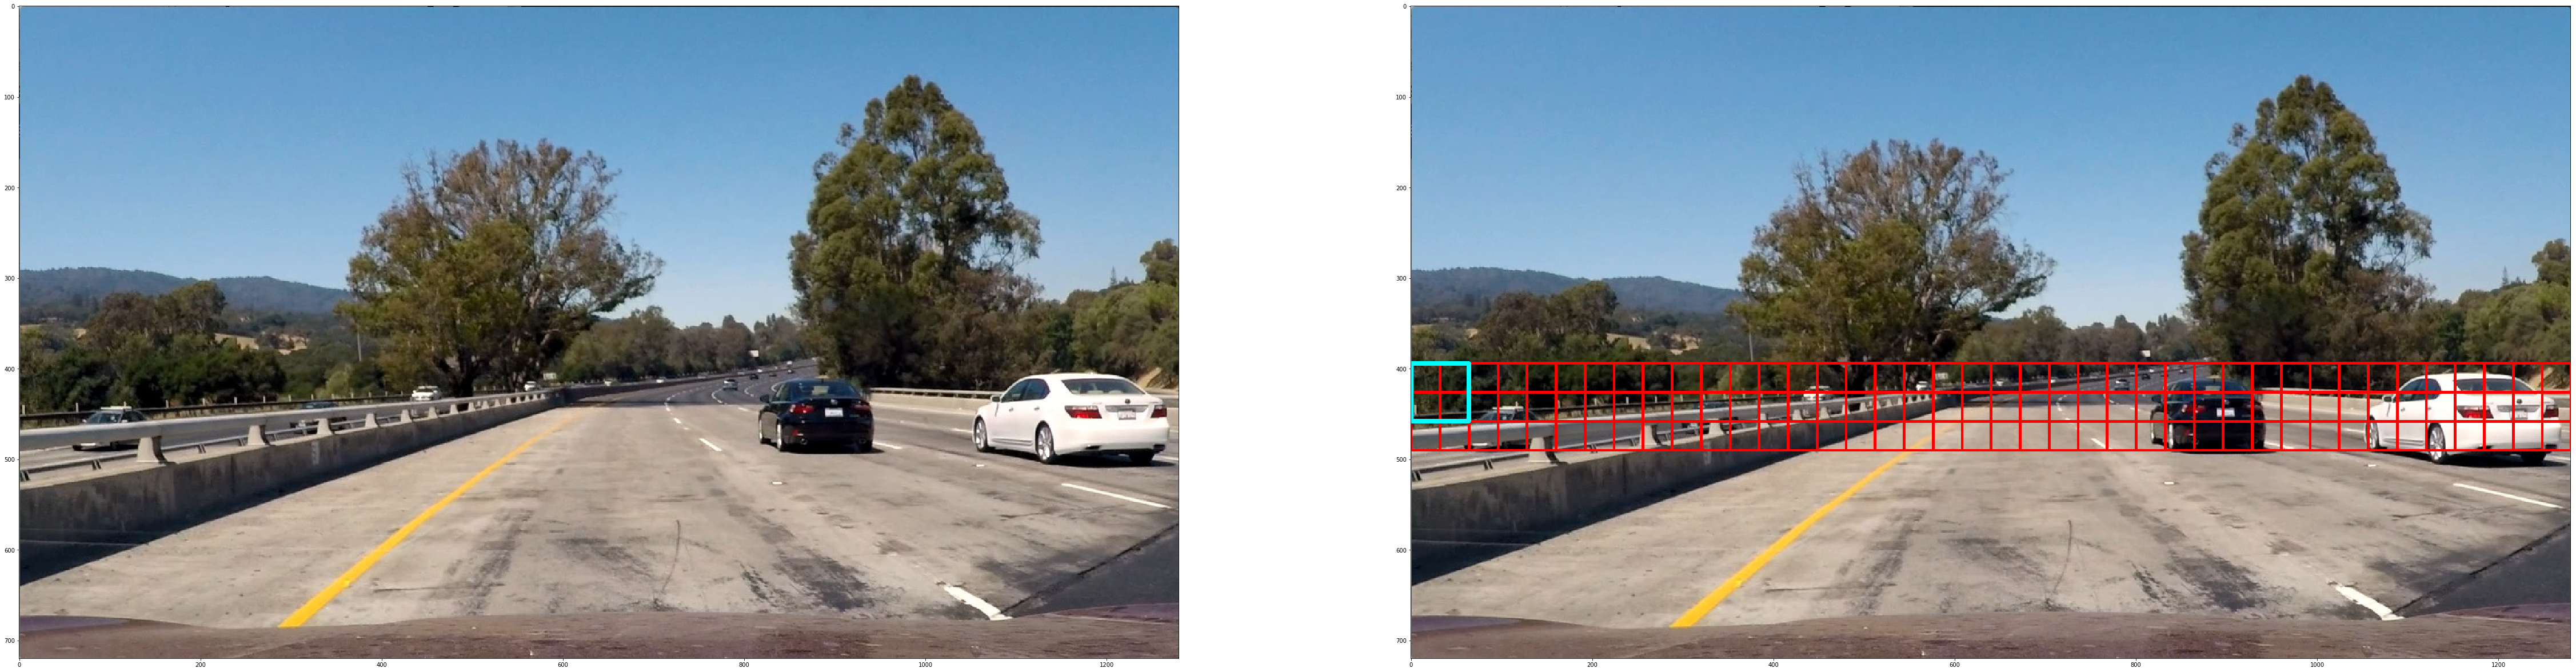

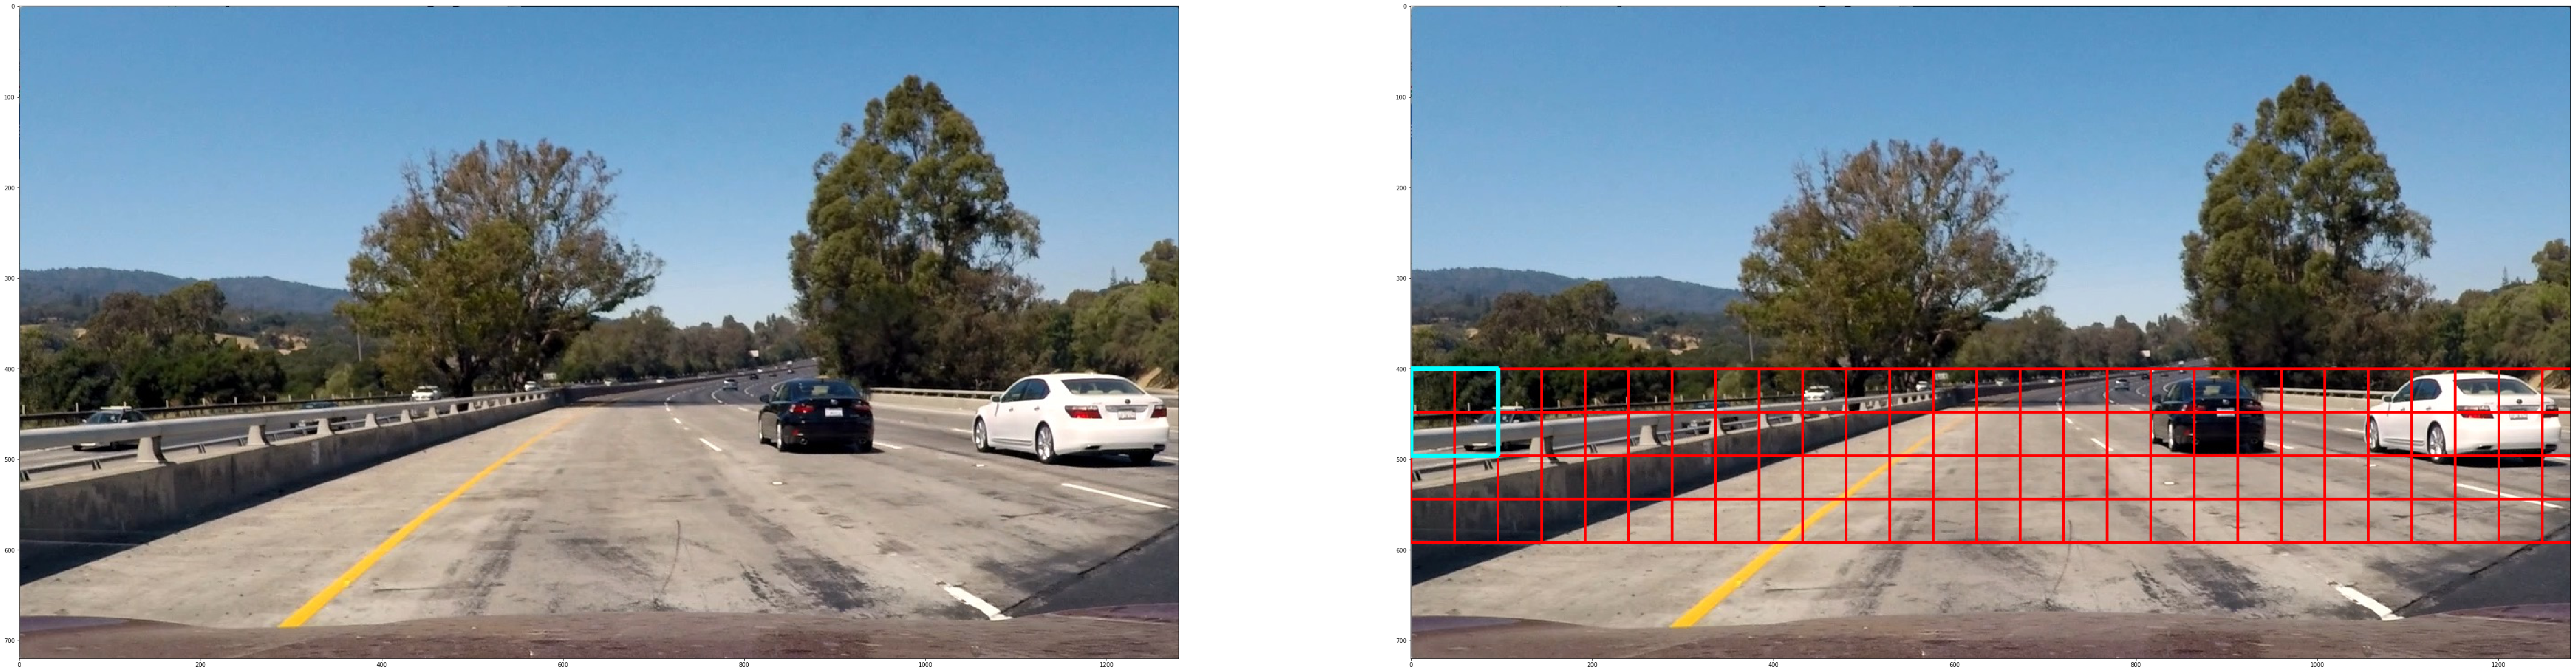

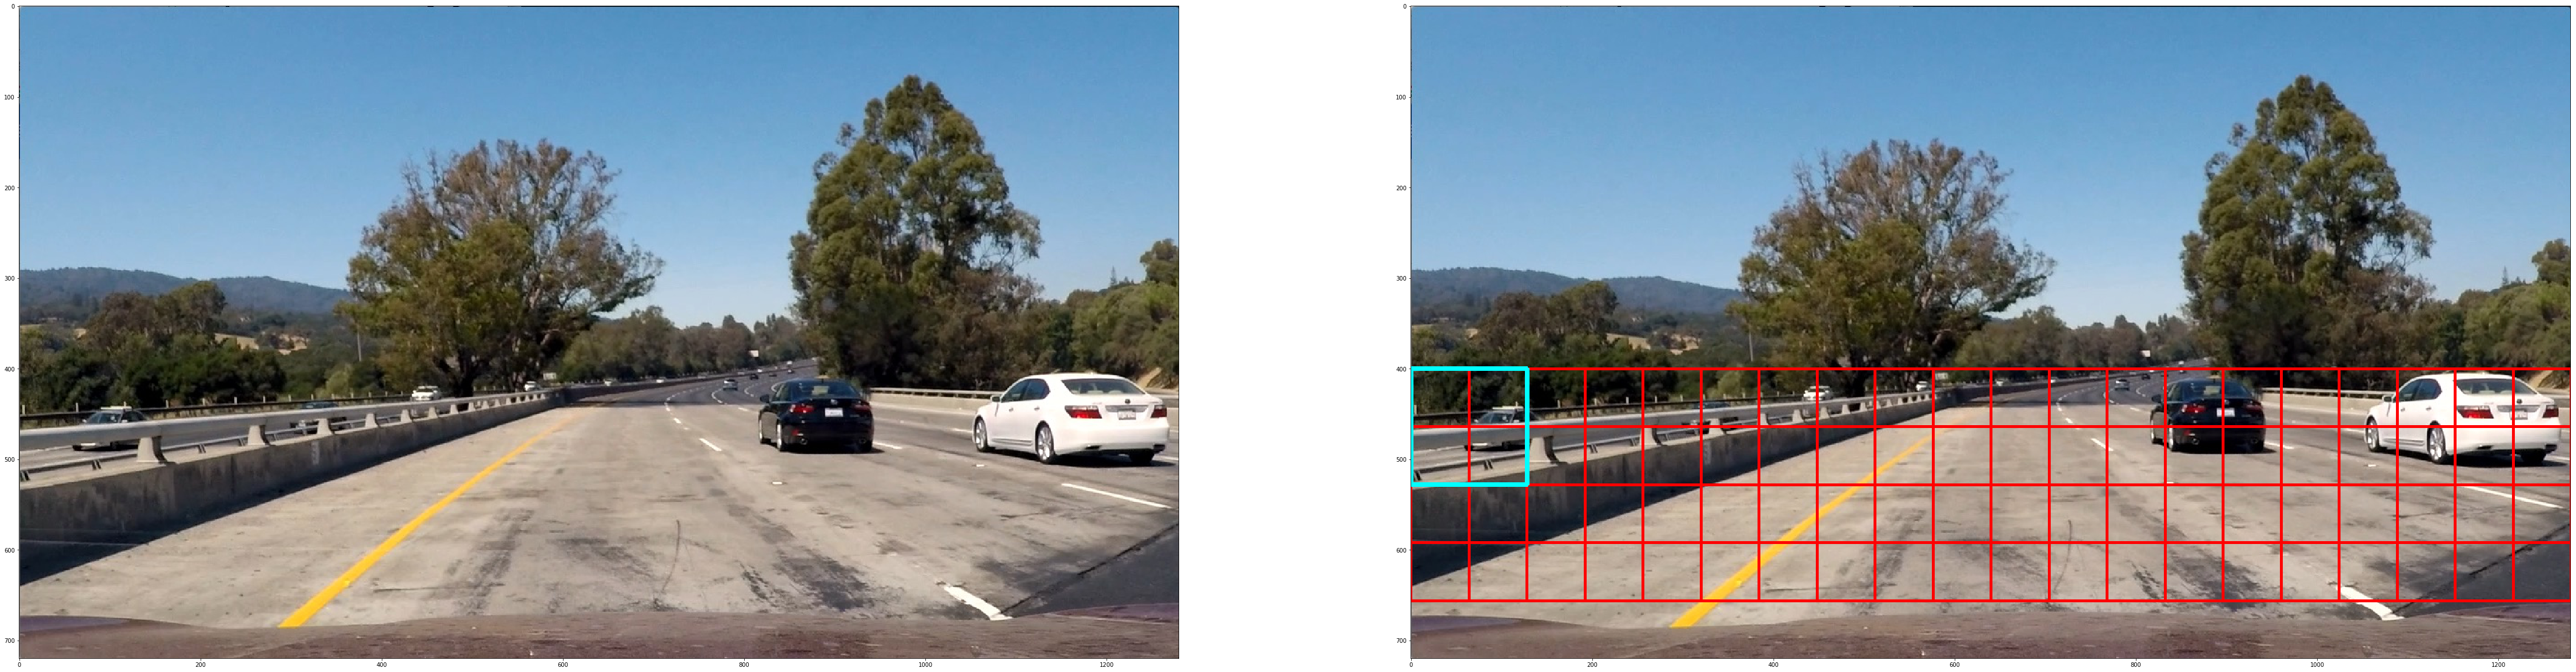

In [4]:
img = mpimg.imread("test_images/"  + test_images[0])
print (img.shape)

scale = 1
w_size = 64 *scale
y_start_stop = (394,434)
x_start_stop = (None, None)
xy_overlap = (0.5,0.5)
window_list = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(w_size, w_size), xy_overlap=xy_overlap)
draw_windows_on_test_image(img,window_list,w_size)

scale = 1.5
w_size = 64*scale
y_start_stop = (400,500)
x_start_stop = (None, None)
xy_overlap = (0.5,0.5)
window_list = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(w_size, w_size), xy_overlap=xy_overlap)
draw_windows_on_test_image(img,window_list,w_size)

scale = 2.0
w_size = 64*scale
y_start_stop = (400,580)
x_start_stop = (None, None)
xy_overlap = (0.5,0.5)
window_list = slide_window(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(w_size, w_size), xy_overlap=xy_overlap)
draw_windows_on_test_image(img,window_list,w_size)


The next step is to extract the features and search classify each window. However extracting HOG features at each step is time consuming. In order to avoid it I will modify th code

In [5]:

def cvt_colorspace(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    return feature_image

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        feature_vec=True):
            
    vis=False  
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
    return features


In [7]:

def find_cars(img, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,window,colorspace,draw=False):
    found_windows = []
    if draw:
        draw_img = np.copy(img)
    img2 = cvt_colorspace(img,colorspace)
    
    img_cropped = img2[y_start_stop[0]:y_start_stop[1],:,:]
    
    if scale is not 1:
        imshape = img_cropped.shape
        img_cropped = cv2.resize(img_cropped, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = img_cropped[:,:,0]
    ch2 = img_cropped[:,:,1]
    ch3 = img_cropped[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    #print (nxsteps)
    #print (nysteps)
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_cropped[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, hist_features, )).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                found_windows.append(((xbox_left, ytop_draw+y_start_stop[0]),(xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0])))
                if (draw):
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+y_start_stop[0]),(xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0]),(0,0,255),6) 
    if not draw:
        return found_windows
    return found_windows,draw_img

(720, 1280, 3)
101
5


/Users/Alper/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


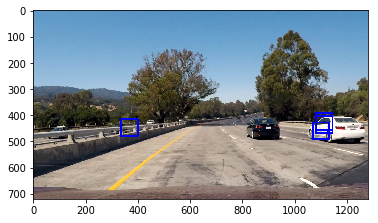

66
3


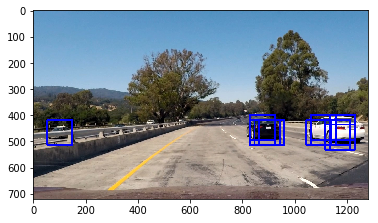

48
2


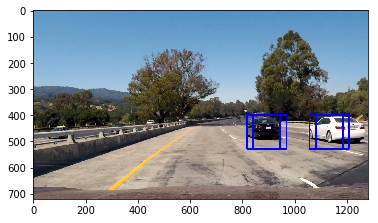

In [8]:
# we will load the model we trained before
from sklearn.externals import joblib

clf = joblib.load('classifier.pkl') 
X_scaler = joblib.load('scale.pkl')


colorspace = 'HSV'
orient = 12
pix_per_cell = 6
cell_per_block = 3
# we will use all of the channels for HOG features
#hog_channel = "ALL"
    
# parameters for Color features
nbins=16
bins_range=(0, 256)

img = mpimg.imread("test_images/"  + test_images[0])
print (img.shape)

scale = 1
w_size = 64
y_start_stop = (380,500)
found_windows, found_img = find_cars(img, y_start_stop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, 
                                     0, nbins,w_size,colorspace,True)

plt.figure()
plt.imshow(found_img)
plt.show()

scale = 1.5
w_size = 64
y_start_stop = (400,550)

found_windows, found_img = find_cars(img, y_start_stop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, 
                                     0, nbins,w_size,colorspace,True)
plt.figure()
plt.imshow(found_img)
plt.show()

scale = 2.0
w_size = 64
y_start_stop = (400,580)

found_windows, found_img = find_cars(img, y_start_stop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, 
                                     0, nbins,w_size,colorspace,True)
plt.figure()
plt.imshow(found_img)
plt.show()


### Heat Map
 
The detection has false positives and multiple detections in some regions. We will use a heatmap to cancel out the false positives and unite the correcty classified objects.
We will use two additional functions to turn detections into heatmaps.

In [20]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def connetcted_components_labeling(heatmap):
    labels = label(heatmap)
    rectangles = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        rectangles.append(bbox)
    return labels, rectangles

def draw_rectangles_on_image(img, rectangles):
    img2 = img.copy()
    for rectangle in rectangles:
        cv2.rectangle(img2,rectangle[0],rectangle[1] ,(0,0,255),2)
    return img2

101
5


/Users/Alper/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


66
3
48
2


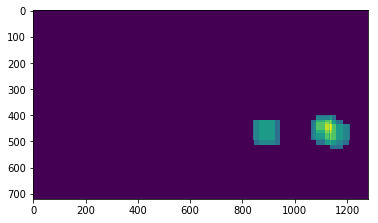

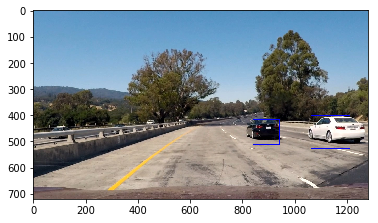

In [25]:
colorspace = 'HSV'
orient = 12
pix_per_cell = 6
cell_per_block = 3
# we will use all of the channels for HOG features
#hog_channl = "ALL"
    
# parameters for Color features
nbins=16
bins_range=(0, 256)

heat_threshold = 3

img = mpimg.imread("test_images/"  + test_images[0])
#print (img.shape)

heat_map = np.zeros_like(img[:,:,0])

scale = 1
w_size = 64
y_start_stop = (380,500)
found_windows = find_cars(img, y_start_stop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, 
                          0, nbins,w_size,colorspace,False)
add_heat(heat_map,found_windows)


scale = 1.5
y_start_stop = (400,550)
found_windows = find_cars(img, y_start_stop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, 
                          0, nbins,w_size,colorspace,False)
add_heat(heat_map,found_windows)

scale = 2.0
y_start_stop = (400,580)
found_windows = find_cars(img, y_start_stop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, 
                          0, nbins,w_size,colorspace,False)
add_heat(heat_map,found_windows)

final_heat = apply_threshold(heat_map,heat_threshold)
labels,rectangles = connetcted_components_labeling(final_heat)
rectangle_image = draw_rectangles_on_image(img,rectangles)
#print (rectangle_image.shape)

plt.figure()
plt.imshow(final_heat)
plt.show()

plt.figure()
plt.imshow(rectangle_image)
plt.show()

## Video Processing

For performance reasons I combined these functions in 'ProcessVideo.py' file.